In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from PIL import Image
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fractions import Fraction
font = {'family' : 'Times New Roman',
    'weight' : 'light',
    'size'   : 13,
    }
plt.rc('font',family='Times New Roman')

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

#def curve_color():
def set_axis(axes,xmaj=0.5,xmin=0.125,ymaj=0.5,ymin=0.125,aspect=None):
    if aspect:
        axes.set_aspect(aspect)
    axes.minorticks_on()
    axes.tick_params(axis="both", which="major", direction="in", width=1, length=4, labelsize=10)
    axes.tick_params(axis="both", which="minor", direction="in", width=1, length=2, labelsize=10)

    axes.xaxis.set_major_locator(MultipleLocator(xmaj))
    axes.xaxis.set_minor_locator(MultipleLocator(xmin))
    axes.yaxis.set_major_locator(MultipleLocator(ymaj))
    axes.yaxis.set_minor_locator(MultipleLocator(ymin))

In [2]:
class solver:
    def __init__(self,nx=100,nt=1000,ts=0.25,gamma=1.4):
        """"
        nx: the number of cells, or the total number of nodes is nx+1
        nt: the number of iterations
        u_curr: u^n; u_next: u^{n+1}
        """
        self.gamma=gamma
        self.nx=nx
        self.nt=nt
        
        self.dx=1./nx
        self.dt=ts/nt
        #self.x_range=np.arange(-0.5,0.5+self.dx,self.dx)
        self.x_range=np.arange(-0.5,0.5+2*self.dx,self.dx)
        self.t_range=np.arange(0,ts+self.dt,self.dt)

        self.u_curr=np.zeros((3,nx+2))
        self.u1_curr=np.zeros((3,nx+2))

        a=np.tile(np.where(self.x_range<=0,1,0),3).reshape(3,nx+2)
        a1=np.tile(np.array([1,0.75,1]),nx+2).reshape(nx+2,3).T
        a2=np.tile(np.array([0.125,0,0.1]),nx+2).reshape(nx+2,3).T
        self.u1_curr=a1*a+a2*(1-a)
        self.u_curr[0]=self.u1_curr[0]
        self.u_curr[1]=self.u1_curr[1]*self.u1_curr[0]
        self.u_curr[2]=self.u1_curr[2]/(gamma-1)+1/2*self.u1_curr[0]*self.u1_curr[1]**2
        #print(self.u_curr)

    def eps2(self,u_curr):
        pass

    def eps4(self,eps2):
        pass


    def method(self, u_curr, u1_curr):
        """"
        Calculate u_next with u_curr, update and return u_curr and u_next
        """
        flux=np.zeros((3,self.nx+2))
        
        flux[0]=u_curr[1]
        flux[1]=u1_curr[1]**2*u1_curr[0]+u1_curr[2]
        flux[2]=(self.gamma*u1_curr[2]/(self.gamma-1)+1/2*u1_curr[0]*u1_curr[1]**2)*u1_curr[1]
        #print(flux)
        lamb=1/2*(np.abs(u1_curr[1])+np.abs(np.roll(u1_curr[1],shift=-1)))+np.sqrt(self.gamma*u1_curr[2]/u1_curr[0])
        eps2=self.eps2(u1_curr)
        eps4=self.eps4(eps2)
        
        #print(flux.shape,u_curr.shape,lamb.shape,eps.shape)
        half_flux=1/2*(np.roll(flux,axis=1,shift=-1)+flux)-lamb*eps2*(np.roll(u_curr,axis=1,shift=-1)-u_curr)\
            -lamb*eps4*(np.roll(u_curr,axis=1,shift=-2)-3*np.roll(u_curr,axis=1,shift=-2)+3*u_curr-np.roll(u_curr,axis=1,shift=1))
        return u_curr - self.dt/self.dx*(half_flux-np.roll(half_flux,axis=1,shift=1))

    def saves(self,arg,tt,data,i):
        if 'freq' in arg.keys() and tt%arg['freq']==0:
            arg['list'].append((tt,data))
        elif 'time' in arg.keys() and i<len(arg['time']) and tt*self.dt<=arg['time'][i]<(tt+1)*self.dt:
            arg['list'].append((tt,data))
            return True
    
    def solve(self, arg_save=None):
        print('Solving the equation, nt: {}'.format(self.nt))    
        i=0
        for tt in range(self.nt+1):
            if arg_save and self.saves(arg_save, tt, self.u1_curr.copy(),i):
                i+=1
                #arg_save['list'].append((tt,self.u_curr.copy()))
            self.u_curr=self.method(self.u_curr.copy(), self.u1_curr.copy())
            self.u_curr[:,0]=np.array([1,0.75,2.78125])
            self.u_curr[:,-2]=np.array([0.125,0,0.25])
            self.u_curr[:,-1]=np.array([0.125,0,0.25])
            self.u1_curr[0]=self.u_curr[0]
            self.u1_curr[1]=self.u_curr[1]/self.u_curr[0]
            self.u1_curr[2]=(self.gamma-1)*(self.u_curr[2]-1/2*self.u1_curr[0]*self.u1_curr[1]**2)
        

In [ ]:
set_save_t=lambda _list, time=1: {'list': _list, 'time':time}
class plotter:
    def __init__(self):
        self._list=[]
        self.time_list=[]
        
    def plot_result_t1(self,exact=1):
        path="C:/Users/Cx_330/Documents/MATLAB/Riemann/"
        def txt_to_vectors(file_path, delimiter=' '):
            vectors = []
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    line = line.strip()
                    if line:  # 跳过空行
                        try:
                            vector = [float(num) for num in line.split(delimiter)]
                            vectors.append(vector)
                        except ValueError:
                            print(f"忽略无效行：{line}")
            return np.array(vectors)
        #f, axarr = plt.subplots(5, 3, figsize=(10, 8),sharex=True)
            
        #self._list=_list
        #print(len(self._list))
        f, axarr = plt.subplots(len(self._list), 3, figsize=(10, 4),sharex=True)
        plt.gcf().subplots_adjust(bottom=0.25)
        for i in range(len(self._list)):
            if exact:
                file_path=path+'ExactSol_{:.2f}.txt'.format(self._list[i][0]*self.dt)

                vectors = txt_to_vectors(file_path)
                
                axarr[i][0].plot(vectors[0],vectors[2],color='r',linestyle='--',label=r'Exact Solution - $\rho$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[i][1].plot(vectors[0],vectors[1],color='g',linestyle='--',label=r'Exact Solution - $u$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[i][2].plot(vectors[0],vectors[3],color='b',linestyle='--',label=r'Exact Solution - $p$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))

            #print(self._list[i][0])
            set_axis(axarr[i][0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            set_axis(axarr[i][1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            set_axis(axarr[i][2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            
            axarr[i][1].set_xlim([-0.6, 0.6])
            axarr[i][0].set_xlim([-0.6, 0.6])
            axarr[i][2].set_xlim([-0.6, 0.6])
            axarr[i][1].set_ylim([-0.1, 2.1])
            axarr[i][0].set_ylim([-0.1, 1.1])
            axarr[i][2].set_ylim([-0.1, 1.1])
            
            axarr[i][0].set_xlabel(r'$x$')
            axarr[i][1].set_xlabel(r'$x$')
            axarr[i][2].set_xlabel(r'$x$')
            axarr[i][0].set_ylabel(r'$\rho$')
            axarr[i][1].set_ylabel(r'$u$')
            axarr[i][2].set_ylabel(r'$p$')
            axarr[i][0].text(0.25,0.85,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][1].text(0.25,1.6,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][2].text(0.25,0.85,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][0].plot(self.x_range,self._list[i][1][0],'r',label=r'Numerical Solution - $\rho$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            axarr[i][1].plot(self.x_range,self._list[i][1][1],'g',label=r'Numerical Solution - $u$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            axarr[i][2].plot(self.x_range,self._list[i][1][2],'b',label=r'Numerical Solution - $p$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            
            #axarr[i][0].legend(loc='upper right')
            #axarr[i][1].legend(loc='upper right')
            #axarr[i][2].legend(loc='upper right')
            lines = []
            labels = []
            for ax in axarr[0]:
                axLine, axLabel = ax.get_legend_handles_labels()
                lines.extend(axLine)
                labels.extend(axLabel)

            f.legend(lines, labels,           
                    loc = 'lower center', ncols=3)  # 图例的位置，bbox_to_anchor=(0.5, 0.92),
        
        plt.show()

    def plot_result_t(self,exact=1):
        path="./Riemann/"
        def txt_to_vectors(file_path, delimiter=' '):
            vectors = []
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    line = line.strip()
                    if line:  # 跳过空行
                        try:
                            vector = [float(num) for num in line.split(delimiter)]
                            vectors.append(vector)
                        except ValueError:
                            print(f"忽略无效行：{line}")
            return np.array(vectors)
        #self._list=_list
        #print(len(self._list))
        for i in range(len(self._list)):
            f, axarr = plt.subplots(1, 3, figsize=(12, 3))
            if exact:
                file_path=path+'ExactSol_{:.2f}.txt'.format(self._list[i][0]*self.dt)

                vectors = txt_to_vectors(file_path)
                
                axarr[0].plot(vectors[0],vectors[2],color='r',linestyle='--',label=r'Exact Solution - $\rho$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[1].plot(vectors[0],vectors[1],color='g',linestyle='--',label=r'Exact Solution - $u$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[2].plot(vectors[0],vectors[3],color='b',linestyle='--',label=r'Exact Solution - $p$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))

            #print(self._list[i][0])
            set_axis(axarr[0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            set_axis(axarr[1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            set_axis(axarr[2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            
            axarr[1].set_xlim([-0.6, 0.6])
            axarr[0].set_xlim([-0.6, 0.6])
            axarr[2].set_xlim([-0.6, 0.6])
            axarr[1].set_ylim([-0.1, 2.1])
            axarr[0].set_ylim([-0.1, 1.1])
            axarr[2].set_ylim([-0.1, 1.1])
            axarr[0].text(0.25,0.85,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[1].text(0.25,1.6,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[2].text(0.25,0.85,r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[0].set_xlabel(r'$x$')
            axarr[1].set_xlabel(r'$x$')
            axarr[2].set_xlabel(r'$x$')
            axarr[0].set_ylabel(r'$\rho$')
            axarr[1].set_ylabel(r'$u$')
            axarr[2].set_ylabel(r'$p$')
            axarr[0].plot(self.x_range,self._list[i][1][0],'r',label=r'Numerical Solution - $\rho$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            axarr[1].plot(self.x_range,self._list[i][1][1],'g',label=r'Numerical Solution - u$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            axarr[2].plot(self.x_range,self._list[i][1][2],'b',label=r'Numerical Solution - $p$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #axarr[i].set_ylim(-0.3, 2.2)
            axarr[0].legend(loc='upper right')
            axarr[1].legend(loc='upper right')
            axarr[2].legend(loc='upper right')
            f.suptitle('Shock Tube Problem ($t = {:.3f}$s)'.format(round(self.dt*self._list[i][0], 3)))
            plt.show()

    def animation(self,name):
        fig, axs = plt.subplots(3,sharex=True)

        line_1, = axs[0].plot(self.x_range, self._list[0][1][0], 'cornflowerblue', label = 'Velocity')
        line_2, = axs[1].plot(self.x_range, self._list[0][1][1], 'lightgreen', label = 'Density')
        line_3, = axs[2].plot(self.x_range, self._list[0][1][2], 'pink', label = 'Pressure')

        axs[0].legend(loc='upper right')
        axs[1].legend(loc='upper right')
        axs[2].legend(loc='upper right')

        axs[0].set_ylim([-0.1, 2.1])
        axs[1].set_ylim([-0.1, 1.1])
        axs[2].set_ylim([-0.1, 1.1])

        axs[0].set_ylabel('Velocity($u$)')
        axs[1].set_ylabel('Dentsity($\\rho$)')
        axs[2].set_xlabel('Space($x$)')
        axs[2].set_ylabel('Pressure($p$)')

        set_axis(axs[0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        set_axis(axs[1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        set_axis(axs[2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        def update(num, u, rho, p , line_1, line_2, line_3):
            line_1.set_ydata(u[:, num])
            line_2.set_ydata(rho[:, num])
            line_3.set_ydata(p[:, num])
            fig.suptitle('Shock Tube Problem ($t = {:.3f}$s)'.format(round(self.dt*num, 3)))
            return line_1,line_2,line_3,
    
        plt_u=np.zeros((len(self._list),self.nx+2))
        plt_rho=np.zeros((len(self._list),self.nx+2))
        plt_p=np.zeros((len(self._list),self.nx+2))
        for i in range(len(self._list)):
            plt_u[i]=self._list[i][1][1]
            plt_rho[i]=self._list[i][1][0]
            plt_p[i]=self._list[i][1][2]
        plt_u=plt_u.T
        plt_rho=plt_rho.T
        plt_p=plt_p.T
        ani = FuncAnimation(fig, update, frames=range(1,len(self._list),20), fargs=[plt_u,plt_rho,plt_p,line_1,line_2,line_3], interval = 10)
            
        ani.save(name+'.gif', writer='pillow')
        plt.show()

In [4]:
class Rusanov(solver,plotter):
    def __init__(self,nx=100,nt=1000,ts=0.25,gamma=1.4):
        super().__init__(nx,nt,ts,gamma)
        self._list=[]
        self.time_list=[i for i in self.t_range]#[0,0.05,0.10,0.15,0.20,0.25]
        print('Method: Rusanov, nx: {}, dx: {}, dt: {}, dt: {}'.format(self.nx, self.dx, self.nt, self.dt))
    
    def eps2(self,u_curr):
        return 1/2*np.ones(self.nx+2)
    
    def eps4(self,u_curr):
        return 0
    
    def solve(self):
        solver.solve(self,arg_save=set_save_t(self._list,self.time_list))

In [5]:
class Jameson(solver,plotter):
    def __init__(self,nx=100,nt=1000,ts=0.25,k2=0.5,k4=1/64,gamma=1.4):
        super().__init__(nx,nt,ts,gamma)
        self._list=[]
        self.time_list=[i for i in self.t_range]#[0,0.05,0.10,0.15,0.20,0.25]
        self.k2=k2
        self.k4=k4
        print('Method: Jameson, nx: {}, dx: {}, dt: {}, dt: {}'.format(self.nx, self.dx, self.nt, self.dt))
    
    def eps2(self,u_curr):
        v=np.abs(np.roll(u_curr[2],shift=-1)-2*u_curr[2]+np.roll(u_curr[2],shift=1))/np.abs(np.roll(u_curr[2],shift=-1)+2*u_curr[2]+np.roll(u_curr[2],shift=1))
        ans=np.concatenate((np.roll(v,shift=1),v,np.roll(v,shift=-1),np.roll(v,shift=-2)))
        ans=ans.reshape(4,self.nx+2)
        return self.k2*np.max(ans,axis=0)
    
    def eps4(self,eps2):
        temp=self.k4-eps2
        return (temp)*(temp>0)
    
    def solve(self):
        solver.solve(self,arg_save=set_save_t(self._list,self.time_list))

Method: Rusanov, nx: 100, dx: 0.01, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


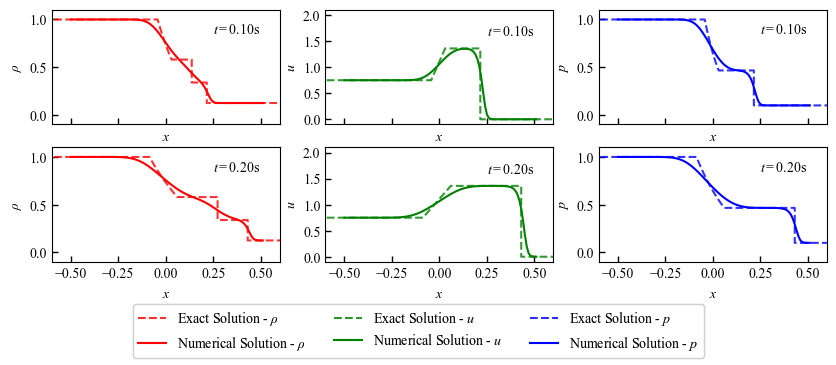

In [6]:
rus=Rusanov(nt=1000)#nx=100
rus.time_list=[0.10,0.20]#,0.25]
#rus.time_list=[i for i in rus.t_range]
rus.solve()
rus.plot_result_t1()
#rus.animation('rus')

Method: Rusanov, nx: 500, dx: 0.002, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


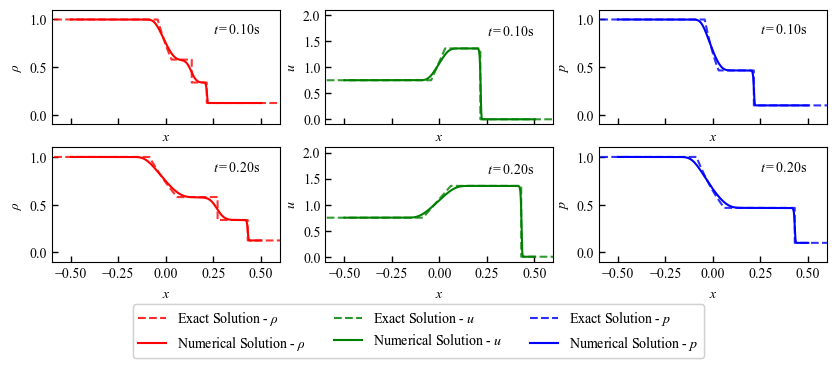

In [7]:
rus=Rusanov(nx=500,nt=1000)#1000->10000
rus.time_list=[0.10,0.20]#,0.25]
#rus.time_list=[i for i in rus.t_range]
rus.solve()
rus.plot_result_t1()
#rus.animation('rus')

Method: Rusanov, nx: 1000, dx: 0.001, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


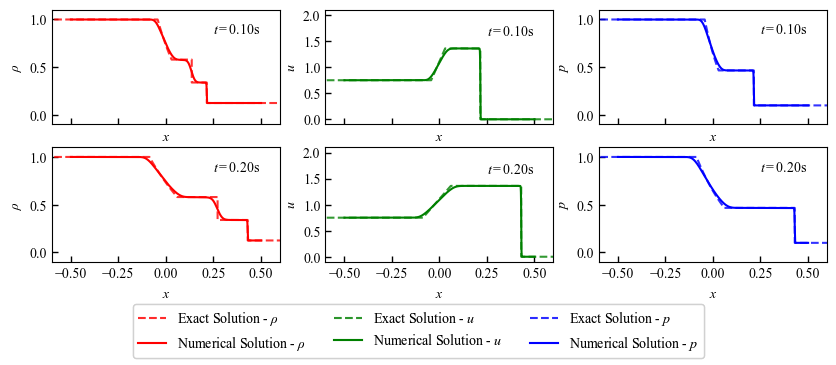

In [8]:
#...
rus=Rusanov(nx=1000,nt=1000)
rus.time_list=[0.10,0.20]#,0.25]
#rus.time_list=[i for i in rus.t_range]
rus.solve()
rus.plot_result_t1()
#rus.animation('rus')

Method: Jameson, nx: 100, dx: 0.01, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


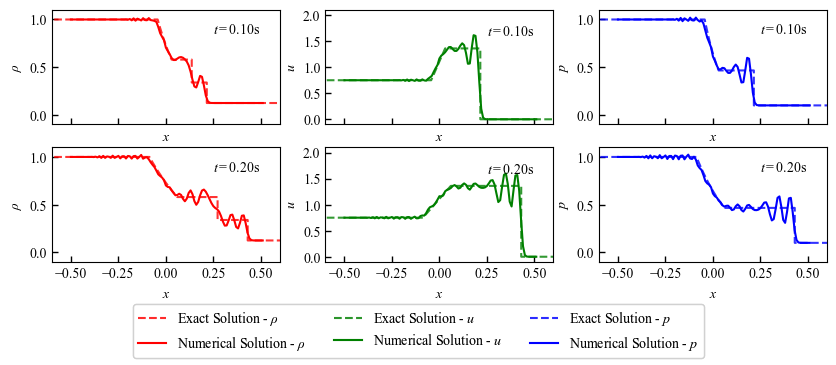

In [9]:
jam=Jameson(nt=1000)#nx=100,k2=0.5,k4=1/64
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam1')


Method: Jameson, nx: 100, dx: 0.01, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


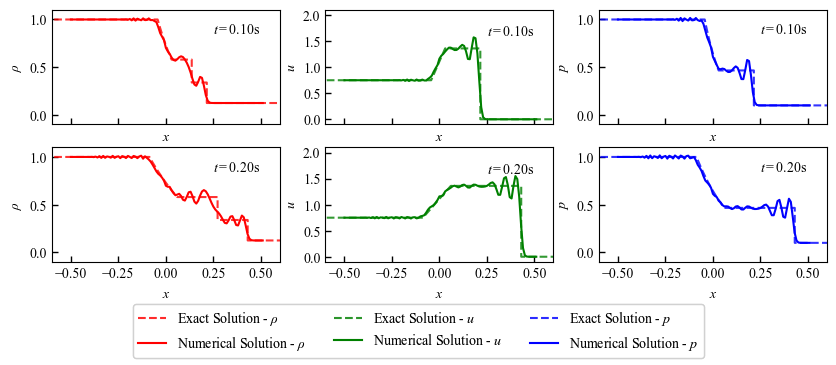

In [10]:
jam=Jameson(nt=10000)#nx=100,k2=0.5,k4=1/64
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam1')


Method: Jameson, nx: 500, dx: 0.002, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


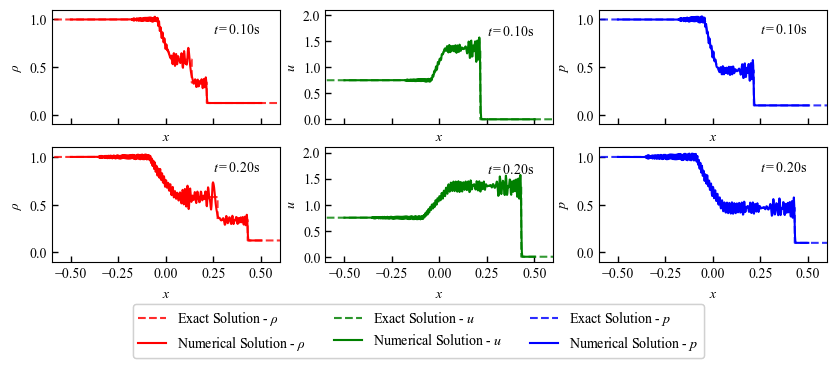

In [11]:
jam=Jameson(nx=500,nt=10000)#k2=0.5,k4=1/64
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam1')


Method: Jameson, nx: 100, dx: 0.01, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


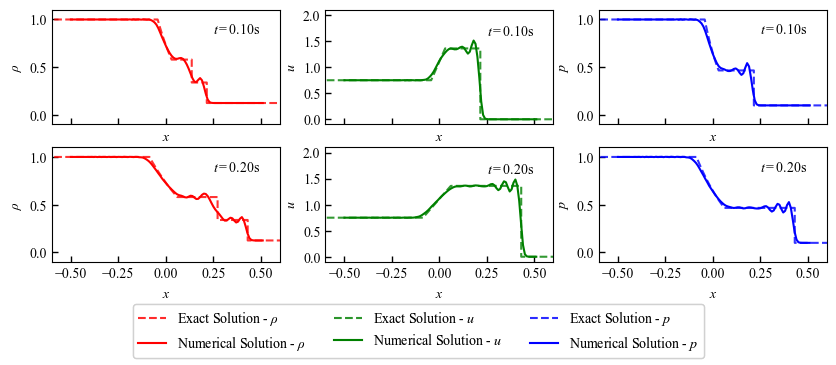

In [12]:
#...
jam=Jameson(nt=1000,k2=2.0,k4=1/256)
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


Method: Jameson, nx: 500, dx: 0.002, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


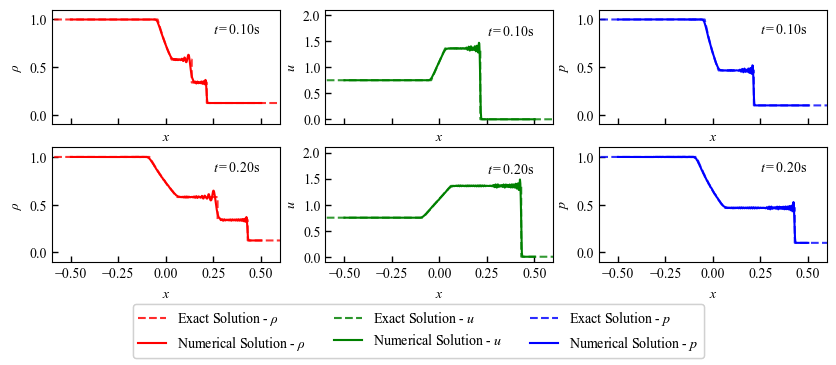

In [13]:

jam=Jameson(nx=500,nt=10000,k2=2.0,k4=1/256)
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


Method: Jameson, nx: 500, dx: 0.002, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


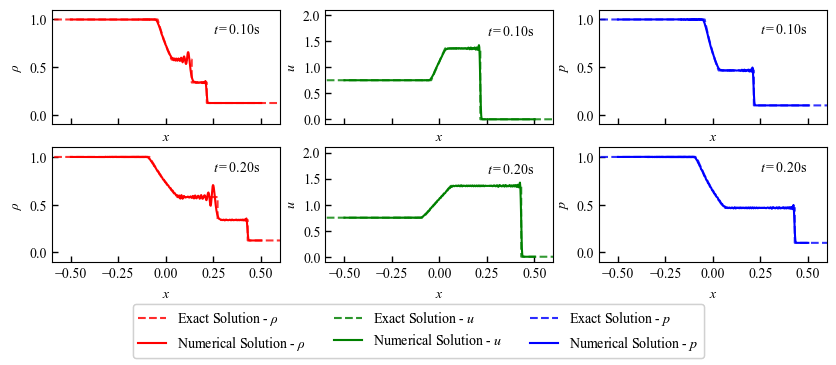

In [14]:
#增大k4色散增强
jam=Jameson(nx=500,nt=10000,k2=5.0,k4=1/64)
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


Method: Jameson, nx: 500, dx: 0.002, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


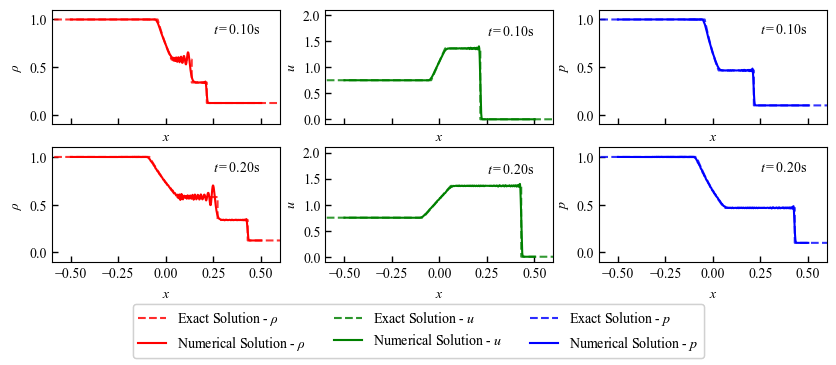

In [15]:

jam=Jameson(nx=500,nt=10000,k2=7,k4=1/64)# k4= 1/32, 1/64, 1/128, 1/256 √
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


Method: Jameson, nx: 100, dx: 0.01, dt: 1000, dt: 0.00025
Solving the equation, nt: 1000


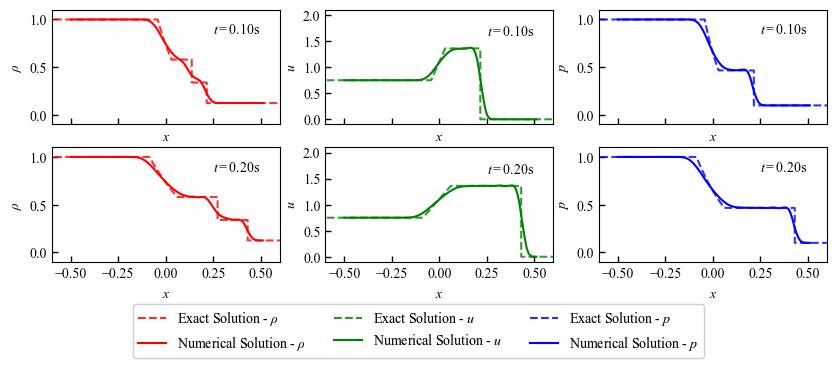

In [16]:

jam=Jameson(nt=1000,k2=20,k4=1/256)
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


Method: Jameson, nx: 500, dx: 0.002, dt: 10000, dt: 2.5e-05
Solving the equation, nt: 10000


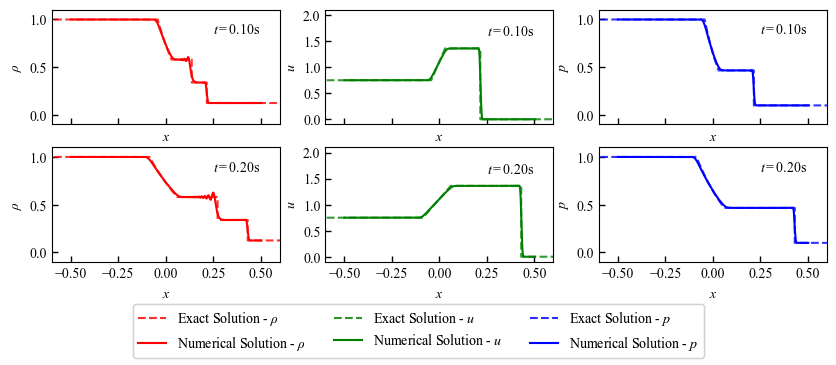

In [17]:

jam=Jameson(nx=500,nt=10000,k2=20,k4=1/256)
jam.time_list=[0.10,0.20]#,0.25]
#jam.time_list=[i for i in rus.t_range]
jam.solve()
jam.plot_result_t1()
#jam.animation('jam2')


shape： (4, 8)
shape： (4, 109)
shape： (4, 109)
shape： (4, 109)
shape： (4, 109)


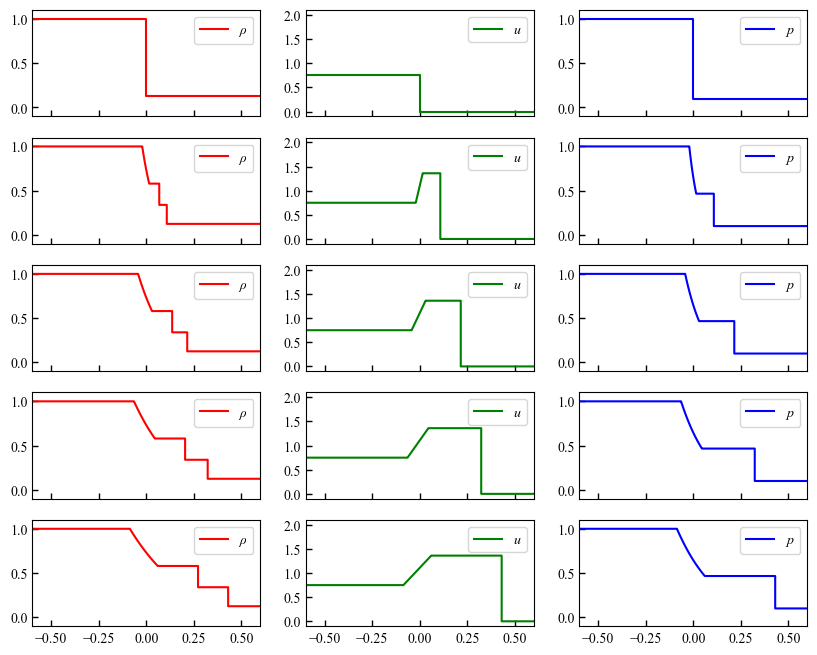

In [ ]:
path="./Riemann/"
import numpy as np
import matplotlib.pyplot as plt

def txt_to_vectors(file_path, delimiter=' '):
    vectors = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:  # 跳过空行
                try:
                    vector = [float(num) for num in line.split(delimiter)]
                    vectors.append(vector)
                except ValueError:
                    print(f"忽略无效行：{line}")
    return np.array(vectors)
f, axarr = plt.subplots(5, 3, figsize=(10, 8),sharex=True)
i=0
for t in [0.00,0.05,0.10,0.15,0.20]:
    file_path=path+'ExactSol_{:.2f}.txt'.format(t)

    vectors = txt_to_vectors(file_path)
        #self._list=_list
    print("shape：", vectors.shape)
    set_axis(axarr[i][0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
    set_axis(axarr[i][1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
    set_axis(axarr[i][2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
    
    axarr[i][1].set_xlim([-0.6, 0.6])
    axarr[i][0].set_xlim([-0.6, 0.6])
    axarr[i][2].set_xlim([-0.6, 0.6])
    axarr[i][1].set_ylim([-0.1, 2.1])
    axarr[i][0].set_ylim([-0.1, 1.1])
    axarr[i][2].set_ylim([-0.1, 1.1])
    
    axarr[i][0].plot(vectors[0],vectors[2],color='r',label=r'$\rho$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
    axarr[i][1].plot(vectors[0],vectors[1],color='g',label=r'$u$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
    axarr[i][2].plot(vectors[0],vectors[3],color='b',label=r'$p$')#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
    #axarr[i].set_ylim(-0.3, 2.2)
    axarr[i][0].legend(loc='upper right')
    axarr[i][1].legend(loc='upper right')
    axarr[i][2].legend(loc='upper right')
    i+=1
plt.show()